# Transfer Learning with TensorFlow Part 2: Fine-tuning

### Let us import the data

In [1]:
train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

Previously, we've used the ImageDataGenerator class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using tf.keras.utils.image_dataset_from_directory().

In [3]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical", #what type of labels
                                                                 batch_size=32) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
# Check out the class names of our data set
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model 0: Building a transfer learning model using the Keras Functional API

In [8]:
# Create a base model using tf.keras application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze the base model
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# Pass the inputs to the base model ( if using keras.applications, EfficientNetV2 inputs dont have to be normalized)
x = base_model(inputs)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                               validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster 
                                 validation_steps=int(0.25 * len(test_data)))

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Epoch 1/5
24/24 [==============================] - 10s 281ms/step - loss: 1.9539 - accuracy: 0.3920 - val_loss: 1.3778 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 6s 252ms/step - loss: 1.1688 - accuracy: 0.7333 - val_loss: 0.9109 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 6s 245ms/step - loss: 0.8365 - accuracy: 0.8240 - val_loss: 0.7260 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 6s 244ms/step - loss: 0.6929 - accuracy: 0.8293 - val_loss: 0.6020 - val_accuracy: 0.8701
Epoch 5/5
24/24 [==============================] - 6s 244ms/step - loss: 0.6063 - accuracy: 0.8587 - val_loss: 0.5299 - val_accuracy: 0.8898


### Model 1: Feature extraction transfer learning with 10% of data and data augmentation

In [10]:
# Create a functional model with data augmentation
import tensorflow as tf
from keras import layers
from keras.models import Sequential

 # Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = "data_augmentation")

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
     """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
     """
 
     # Setup the input shape for our model
     input_shape = (224, 224, 3)

     # Create the frozen base model
     base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
     base_model.trainable = training

     # Create input and output layers
     inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
     x = data_augmentation(inputs) # augment our training images
     x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
     x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
     outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
     model = tf.keras.Model(inputs, outputs)

     # Compile
     model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=["accuracy"])  
     return model

In [11]:
# Create an instance of model_1 with our new function
model_1 = create_base_model()

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In [12]:
# Setup checkpoint path
checkpoint_path = "../ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The SavedModel format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

In [13]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_1.fit(train_data,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0012 - accuracy: 0.3467
Epoch 1: val_loss improved from inf to 1.48984, saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 11s 339ms/step - loss: 2.0012 - accuracy: 0.3467 - val_loss: 1.4898 - val_accuracy: 0.6365
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4015 - accuracy: 0.6347
Epoch 2: val_loss improved from 1.48984 to 1.06125, saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 7s 308ms/step - loss: 1.4015 - accuracy: 0.6347 - val_loss: 1.0613 - val_accuracy: 0.7401
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0801 - accuracy: 0.7147
Epoch 3: val_loss improved from 1.06125 to 0.84324, saving model to ../ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 7s 294ms/step - loss: 1.0801 - accuracy: 0.714

In [16]:
# Evaluate on the test data
results_10_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 11s 136ms/step - loss: 0.6644 - accuracy: 0.8188


To load saved model weights you can use the the load_weights() method, passing it the path where your saved weights are stored.

In [17]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)
loaded_weights_model_results = model_1.evaluate(test_data)

79/79 [==============================] - 11s 139ms/step - loss: 0.6644 - accuracy: 0.8188


In [18]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

### Model 2: Fine-tuning an existing model on 10% of the data
So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetV2B0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data.

In [19]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

To begin fine-tuning, we'll unfreeze the entire model_1_base_model by setting its trainable attribute to True.

Then we'll refreeze every layer in model_1_base_model except for the last 10 by looping through them and setting their trainable attribute to False.

Finally, we'll recompile the whole model.

In [20]:
# Access the base_model layers of model_2
model_1_base_model = model_1.layers[2]
model_1_base_model.name

'efficientnetv2-b0'

In [22]:
# Make all the layers in the model trainable
model_1_base_model.trainable = True

# Freeze all the layers except for the last 10
for layer in model_1_base_model.layers[:-10]:
    layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


In [23]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_1_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the initial_epoch parameter of the fit() method. We'll pass it the last epoch of the previous model's training history (history_10_percent_data_aug.epoch[-1]).

In [25]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model ( same as model_1 except with more trainable layers)
history_fine_10_percent_data_aug = model_1.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
24/24 [==============================] - 12s 339ms/step - loss: 0.7006 - accuracy: 0.8027 - val_loss: 0.5393 - val_accuracy: 0.8289
Epoch 6/10
24/24 [==============================] - 7s 294ms/step - loss: 0.6161 - accuracy: 0.8053 - val_loss: 0.4611 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 7s 297ms/step - loss: 0.5433 - accuracy: 0.8373 - val_loss: 0.4670 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 7s 298ms/step - loss: 0.5149 - accuracy: 0.8347 - val_loss: 0.4386 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 7s 294ms/step - loss: 0.4724 - accuracy: 0.8413 - val_loss: 0.4320 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 7s 294ms/step - loss: 0.4550 - accuracy: 0.8507 - val_loss: 0.4773 - val_accuracy: 0.8405


In [26]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_1.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 0.4577 - accuracy: 0.8452


In [28]:
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3466666638851166, 0.6346666812896729, 0.7146666646003723, 0.7666666507720947, 0.7933333516120911, 0.8026666641235352, 0.8053333163261414, 0.8373333215713501, 0.8346666693687439, 0.8413333296775818, 0.8506666421890259]


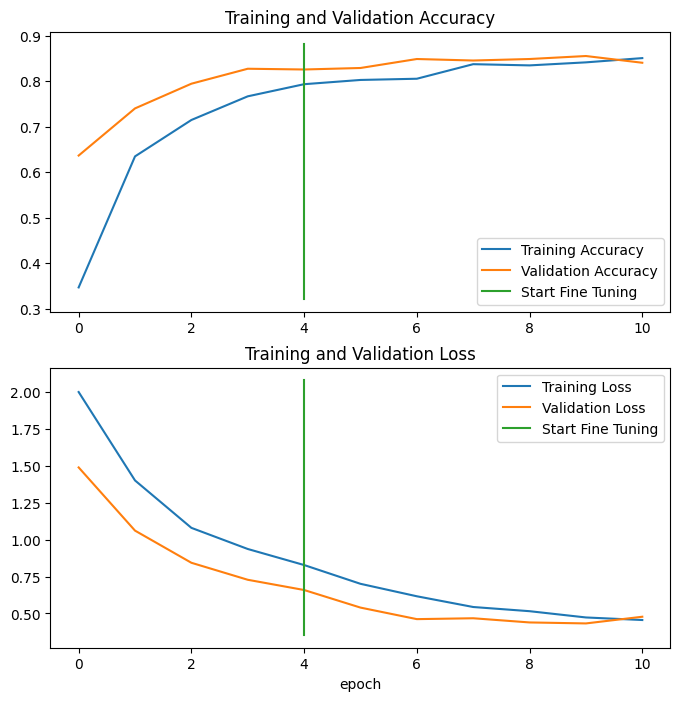

In [29]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

### Model 3: Fine-tuning an existing model all of the data

In [30]:
# Setup data directories
train_dir = "../data/10_food_classes_all_data/train/"
test_dir = "../data/10_food_classes_all_data/test/"

In [31]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [33]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [34]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [35]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [36]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
235/235 [==============================] - 59s 232ms/step - loss: 0.7163 - accuracy: 0.7697 - val_loss: 0.3469 - val_accuracy: 0.8783
Epoch 6/10
235/235 [==============================] - 56s 239ms/step - loss: 0.5945 - accuracy: 0.8073 - val_loss: 0.3270 - val_accuracy: 0.8832
Epoch 7/10
235/235 [==============================] - 57s 242ms/step - loss: 0.5514 - accuracy: 0.8203 - val_loss: 0.2853 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 120s 509ms/step - loss: 0.5079 - accuracy: 0.8411 - val_loss: 0.3030 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 116s 491ms/step - loss: 0.4777 - accuracy: 0.8453 - val_loss: 0.2617 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 67s 283ms/step - loss: 0.4573 - accuracy: 0.8503 - val_loss: 0.2577 - val_accuracy: 0.9095


In [37]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 14s 178ms/step - loss: 0.2875 - accuracy: 0.9064


[0.2874951660633087, 0.9064000248908997]

In [38]:
results_fine_tune_10_percent

[0.45773038268089294, 0.8452000021934509]

5
11
[0.3466666638851166, 0.6346666812896729, 0.7146666646003723, 0.7666666507720947, 0.7933333516120911, 0.7697333097457886, 0.8073333501815796, 0.8202666640281677, 0.8410666584968567, 0.8453333377838135, 0.850266695022583]


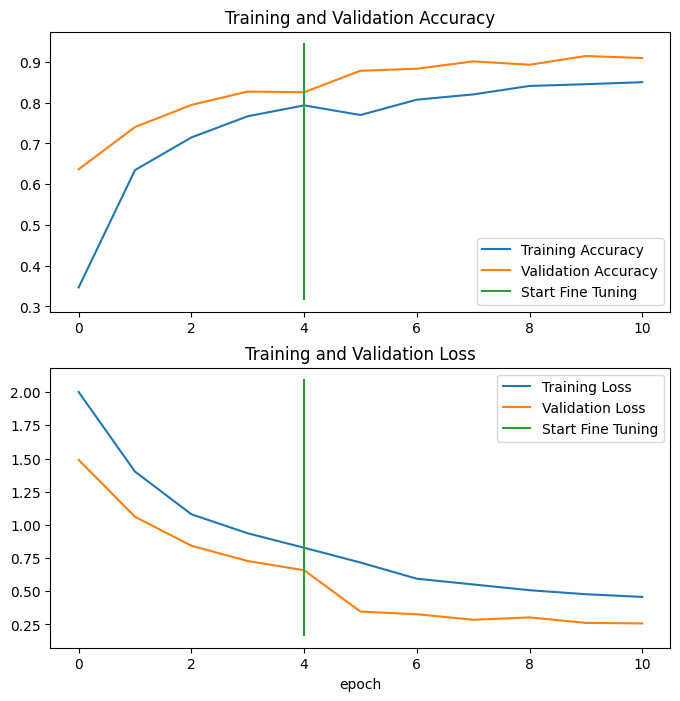

In [39]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)